In [2]:
import pandas as pd
import os
from pathlib import Path
import torch
import torchaudio
from transformers import Wav2Vec2Processor, Wav2Vec2Model
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
meta_path = Path("meta.csv")
df = pd.read_csv(meta_path)
audio_base_path = Path("release_in_the_wild/release_in_the_wild")
df["filepath"] = df["file"].apply(lambda x: audio_base_path / x)

In [42]:
bonafide_count = min(1000, df[df["label"] == "bona-fide"].shape[0])
spoof_count = min(1000, df[df["label"] == "spoof"].shape[0])

bonafide_df = df[df["label"] == "bona-fide"].sample(n=bonafide_count, random_state=42)
spoof_df = df[df["label"] == "spoof"].sample(n=spoof_count, random_state=42)

df = pd.concat([bonafide_df, spoof_df]).reset_index(drop=True)


In [43]:
label_encoder = LabelEncoder()
df["encoded_label"] = label_encoder.fit_transform(df["label"])

In [44]:
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")
model.eval()

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wav2Vec2Model(
  (feature_extractor): Wav2Vec2FeatureEncoder(
    (conv_layers): ModuleList(
      (0): Wav2Vec2GroupNormConvLayer(
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (activation): GELUActivation()
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
      )
      (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
      (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
    )
  )
  (feature_projection): Wav2Vec2FeatureProjection(
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (projection): Linear(in_features=512, out_features=768, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Wav2Vec2Encoder(
    (pos_conv_embed): Wav2Vec2PositionalConvEmbedding(
  

In [45]:
def extract_features(file_path):
    waveform, sample_rate = torchaudio.load(file_path)
    if sample_rate != 16000:
        waveform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)(waveform)
    inputs = processor(waveform.squeeze().numpy(), sampling_rate=16000, return_tensors="pt", padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
        
    hidden_states = outputs.last_hidden_state     # Mean pooling on last hidden state
    features = torch.mean(hidden_states, dim=1).squeeze().numpy()
    return features

Classification Report:
              precision    recall  f1-score   support

   bona-fide       0.80      0.76      0.78        21
       spoof       0.75      0.79      0.77        19

    accuracy                           0.78        40
   macro avg       0.78      0.78      0.77        40
weighted avg       0.78      0.78      0.78        40



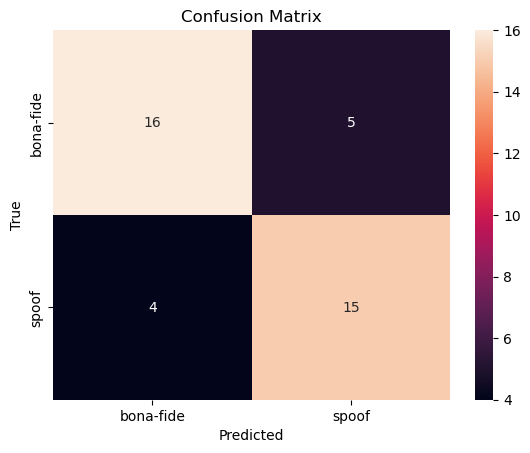

In [46]:
features = []
labels = []

for i, row in df.iterrows():
    try:
        feats = extract_features(row["filepath"])
        features.append(feats)
        labels.append(row["encoded_label"])
    except Exception as e:
        print(f"Error processing {row['filepath']}: {e}")

X = np.array(features)
y = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

svm = SVC(kernel='rbf', C=1, gamma='scale', probability=True)
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [54]:
import pandas as pd
df = pd.read_csv("meta.csv")
label_counts = df["label"].value_counts()
print(label_counts)


label
bona-fide    19963
spoof        11816
Name: count, dtype: int64
